In [ ]:
# see what your run definition looks like
with open(".azureml/explain.runconfig","r") as f:
    print(f.read())

In [ ]:
# see what your package dependencies looks like
with open(".azureml/conda_dependencies.yml","r") as f:
    print(f.read())

In [15]:
#submit and monitor a run
from azureml.core import RunConfiguration, Experiment, Run
from azureml.core.script_run_config import ScriptRunConfig
from azureml.widgets import RunDetails
from azureml.core import Workspace

ws = Workspace.from_config()
runconfig = RunConfiguration.load('.','explain')
src = ScriptRunConfig(source_directory='.',script='train_explain.py',run_config=runconfig)
run = Experiment(ws,'generate-attrition-explainer').submit(src)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [18]:
#!jupyter nbextension install  --py --user azureml.contrib.explain.model.visualize
#!jupyter nbextension enable  --py --user azureml.contrib.explain.model.visualize
#!source activate py36 && jupyter nbextension list

In [17]:
from azureml.contrib.explain.model.visualize import ExplanationDashboard
from azureml.contrib.explain.model.explanation.explanation_client import ExplanationClient
from azureml.core.model import Model
from sklearn.externals import joblib

original_model = Model(ws, 'IBM_attrition_model')
model_path = original_model.download(exist_ok=True)

client = ExplanationClient.from_run(run)
global_explanation = client.download_model_explanation()
attrition_model = joblib.load(model_path)

x_test_path = './x_test.pkl'
run.download_file('x_test_ibm.pkl', output_file_path=x_test_path)

x_test = joblib.load(x_test_path)

ExplanationDashboard(global_explanation, attrition_model, x_test)

ExplanationWidget(value={'localExplanations': [[[0.011139991333791295, 0.0, 0.002154231393631467, 0.0, 0.00718…

In [ ]:
#see what your score file looks like
with open("score.py","r") as f:
    print(f.read())

In [ ]:
#deploy
from azureml.core import Workspace
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig, Model

ws = Workspace.from_config()

scoring_explainer_model = Model(ws, 'IBM_attrition_explainer')
attrition_model = Model(ws, 'IBM_attrition_model')

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "IBM_Attrition",  
                                                     "method" : "local_explanation"}, 
                                               description='Explain predictions on employee attrition')
                                               
inference_config = InferenceConfig(entry_script='score.py', 
                                   extra_docker_file_steps='Dockerfile', 
                                   runtime='python', 
                                   conda_file='myenv.yml')

service = Model.deploy(ws, name='predictattritionsvc', models=[scoring_explainer_model, attrition_model], inference_config= inference_config, deployment_config=aciconfig)

http://52.191.239.245:80/score
prediction: {"predictions": [0], "local_importance_values": [[[0.011893157926831918, 0.0, 0.001948017948270056, 0.0, 0.007483265451196458, 0.0, 0.009660853271403366, -0.017192954971353896, 0.0, 0.0, -0.010145356542845527, -0.016782511147139297, -0.0015557671219139056, 0.0031978832881977143, 0.006866099843478735, 0.02188772568434794, 0.0004925454707126985, 0.0023098392350914057, 0.0, 0.000373374398902053, 0.0, 0.0015539969560965233, 0.0026309279472540546, 0.02159462439982303, -0.0052022765712637885, 0.012417684525554779, 0.012723466385322294, -0.012818438311330942, 0.008945499626888669, -0.014813315343381466]], [[-0.011893157926831911, 0.0, -0.0019480179482700873, 0.0, -0.007483265451196458, 0.0, -0.009660853271403376, 0.01719295497135389, 0.0, 0.0, 0.010145356542845525, 0.016782511147139287, 0.001555767121913916, -0.0031978832881977212, -0.006866099843478756, -0.021887725684347947, -0.0004925454707127019, -0.0023098392350914404, 0.0, -0.000373374398902053

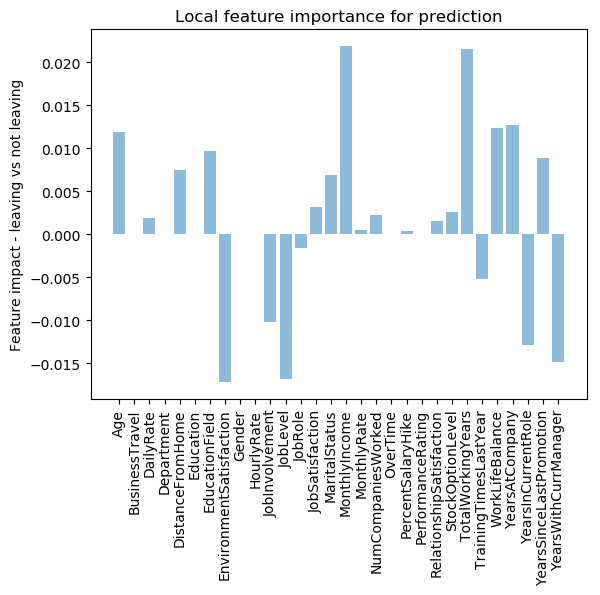

In [21]:
# get URI for querying
from azureml.core.webservice import AciWebservice
import requests
import json

sample = '{"Age":{"899":49},"BusinessTravel":{"899":"Travel_Rarely"},"DailyRate":{"899":1098},"Department":{"899":"Research & Development"},"DistanceFromHome":{"899":4},"Education":{"899":2},"EducationField":{"899":"Medical"},"EnvironmentSatisfaction":{"899":1},"Gender":{"899":"Male"},"HourlyRate":{"899":85},"JobInvolvement":{"899":2},"JobLevel":{"899":5},"JobRole":{"899":"Manager"},"JobSatisfaction":{"899":3},"MaritalStatus":{"899":"Married"},"MonthlyIncome":{"899":18711},"MonthlyRate":{"899":12124},"NumCompaniesWorked":{"899":2},"OverTime":{"899":"No"},"PercentSalaryHike":{"899":13},"PerformanceRating":{"899":3},"RelationshipSatisfaction":{"899":3},"StockOptionLevel":{"899":1},"TotalWorkingYears":{"899":23},"TrainingTimesLastYear":{"899":2},"WorkLifeBalance":{"899":4},"YearsAtCompany":{"899":1},"YearsInCurrentRole":{"899":0},"YearsSinceLastPromotion":{"899":0},"YearsWithCurrManager":{"899":0}}'

service = AciWebservice(ws,"predictattritionsvc")
print(service.scoring_uri)

headers = {'Content-Type':'application/json'}

# send request to service
resp = requests.post(service.scoring_uri, sample, headers=headers)
print("prediction:", resp.text)
result = json.loads(resp.text)

#plot the feature importance for the prediction
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import json

labels = json.loads(sample)
labels = labels.keys()
objects = labels
y_pos = np.arange(len(objects))
performance = result["local_importance_values"][0][0]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylabel('Feature impact - leaving vs not leaving')
plt.title('Local feature importance for prediction')

plt.show()